In [1]:
import sys
sys.path.append('utils')
import os
import argparse
from tqdm import tqdm
import json
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim

from dataset.spot import DailyDataset_pi, get_loader, TOTAL_STD, TOTAL_MEAN, SEASONAL
from utils.tool import clip_grads, to_gpu, picp, mpiw, rpiw, cwc, MyLoss
from utils.pi_models import GRU as Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
seasonal = SEASONAL['2011-12-12':'2016-06-30'].values
trainY_S = seasonal[:-182].reshape(-1)
testY_S = seasonal[-182:].reshape(-1)

In [3]:
dataset = DailyDataset_pi(N=1600, W=21, seasonal=1)
loader = get_loader(dataset, batch_size=64, shuffle=True, num_workers=2)

Data build range: [window(2011-07-25 00:00:00) - 2011-08-15 00:00:00, 2015-12-31 00:00:00]


In [4]:
TEST_LENGTH = 182

trainX, trainY = loader.dataset.get_io('2012-01-01', '2015-12-31')
testX, testY = loader.dataset.get_io('2012-01-01', '2016-06-30')

train_period_output = (trainY.data.numpy().reshape(-1) + trainY_S) * TOTAL_STD
test_period_output = (testY[-TEST_LENGTH:].data.numpy().reshape(-1) + testY_S) * TOTAL_STD
with torch.no_grad():
    train_period_input = to_gpu(trainX)      
    test_period_input = to_gpu(testX)

In [5]:
PATH = './runs/pi/'
run = 'drnn-lube_64_50_0.01_0.003'
model = to_gpu(Model(input_dim=24, hidden_size=64, output_dim=24*2))
model.load_state_dict(torch.load(os.path.join(PATH, run, 'snapshots153.pth')))

In [6]:
test_period_forecast = model.forecast(test_period_input)[0][-TEST_LENGTH:] * TOTAL_STD + TOTAL_MEAN
test_lower_bound = test_period_forecast[:, :24].data.cpu().numpy().reshape(-1) + testY_S * TOTAL_STD
test_upper_bound = test_period_forecast[:, 24:].data.cpu().numpy().reshape(-1) + testY_S * TOTAL_STD

target = test_period_output+ TOTAL_MEAN

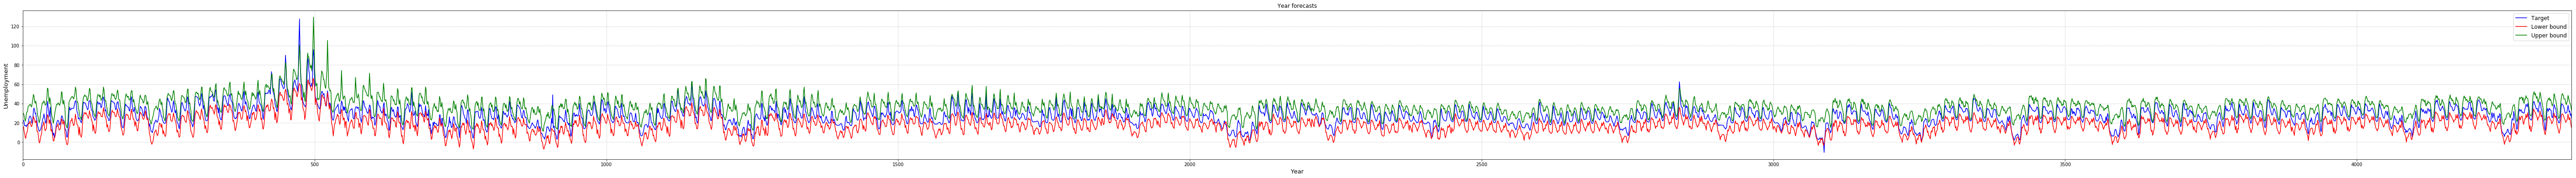

In [7]:
x=np.linspace(1, 182*24, 182*24)
plt.figure(figsize=(100,6))
plt.plot(x, target, color='blue', label='Target')
plt.plot(x, test_lower_bound, color='red', label='Lower bound')
plt.plot(x, test_upper_bound, color='green', label='Upper bound')

plt.xlim(0,182*24)
plt.legend(fontsize='large') # 显示图例

plt.title('Year forecasts')
plt.xlabel('Year',fontsize=13)
plt.ylabel('Unemployment',fontsize=13)

plt.grid(linestyle=':', linewidth=1)
plt.show()

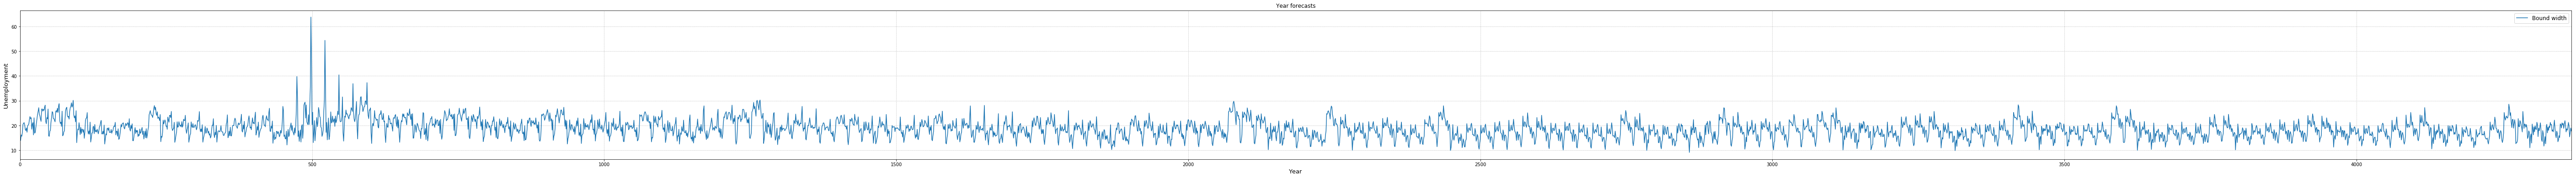

In [8]:
x=np.linspace(1, 182*24, 182*24)
plt.figure(figsize=(100,6))
plt.plot(x, test_upper_bound-test_lower_bound, label='Bound width')

plt.xlim(0,182*24)
plt.legend(fontsize='large') # 显示图例

plt.title('Year forecasts')
plt.xlabel('Year',fontsize=13)
plt.ylabel('Unemployment',fontsize=13)

plt.grid(linestyle=':', linewidth=1)
plt.show()

In [9]:
# save bounds
bounds = np.stack((test_lower_bound, test_upper_bound))
np.save('./bounds/drnn-lube_99.npy', bounds)